In [21]:
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from preprocessing import z_score_outlier_detection
from IPython.core.interactiveshell import InteractiveShell
from utils import calculate_mse, split_data, standardize, calculate_mse_loss
from proj1_helpers import load_csv_data, predict_labels, create_csv_submission

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
InteractiveShell.ast_node_interactivity = "last_expr"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [28]:
TRAIN_PATH = "../data/train.csv"
TEST_PATH = "../data/test.csv"
VAL_PERCENTAGE = 0.4
Z_VALUE = 3.0
DO_Z_OUTLIER_DETECTION = False
Y, X, ids = load_csv_data(TRAIN_PATH)
Y_te, X_te, ids_te = load_csv_data(TEST_PATH)


In [29]:
# standarise 
X = standardize(X)
X_te = standardize(X_te)

In [36]:
# add bias term (column of ones)
X = np.hstack((np.ones((X.shape[0], 1)), X))
X_te = np.hstack((np.ones((X_te.shape[0], 1)), X_te))

# split data
(X_tr, Y_tr, ids_tr), (X_val, Y_val, ids_val) = split_data(X, Y, ids, val_prop=VAL_PERCENTAGE)

## 1. Exploratory data analysis

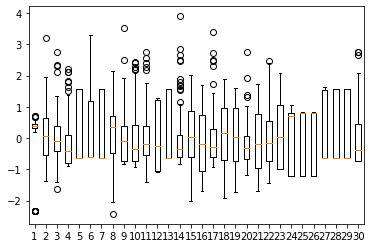

In [32]:
fig, ax1 = plt.subplots(1)

ax1.boxplot(tX[:100,:]);
#ax2.boxplot(tX[:100,15:]);
ax1.set_xlabel('Features')
ax1.set_ylabel('')

In [47]:
import pandas as pd
df = pd.DataFrame(X)
df_s = df.iloc[:100,2:10]

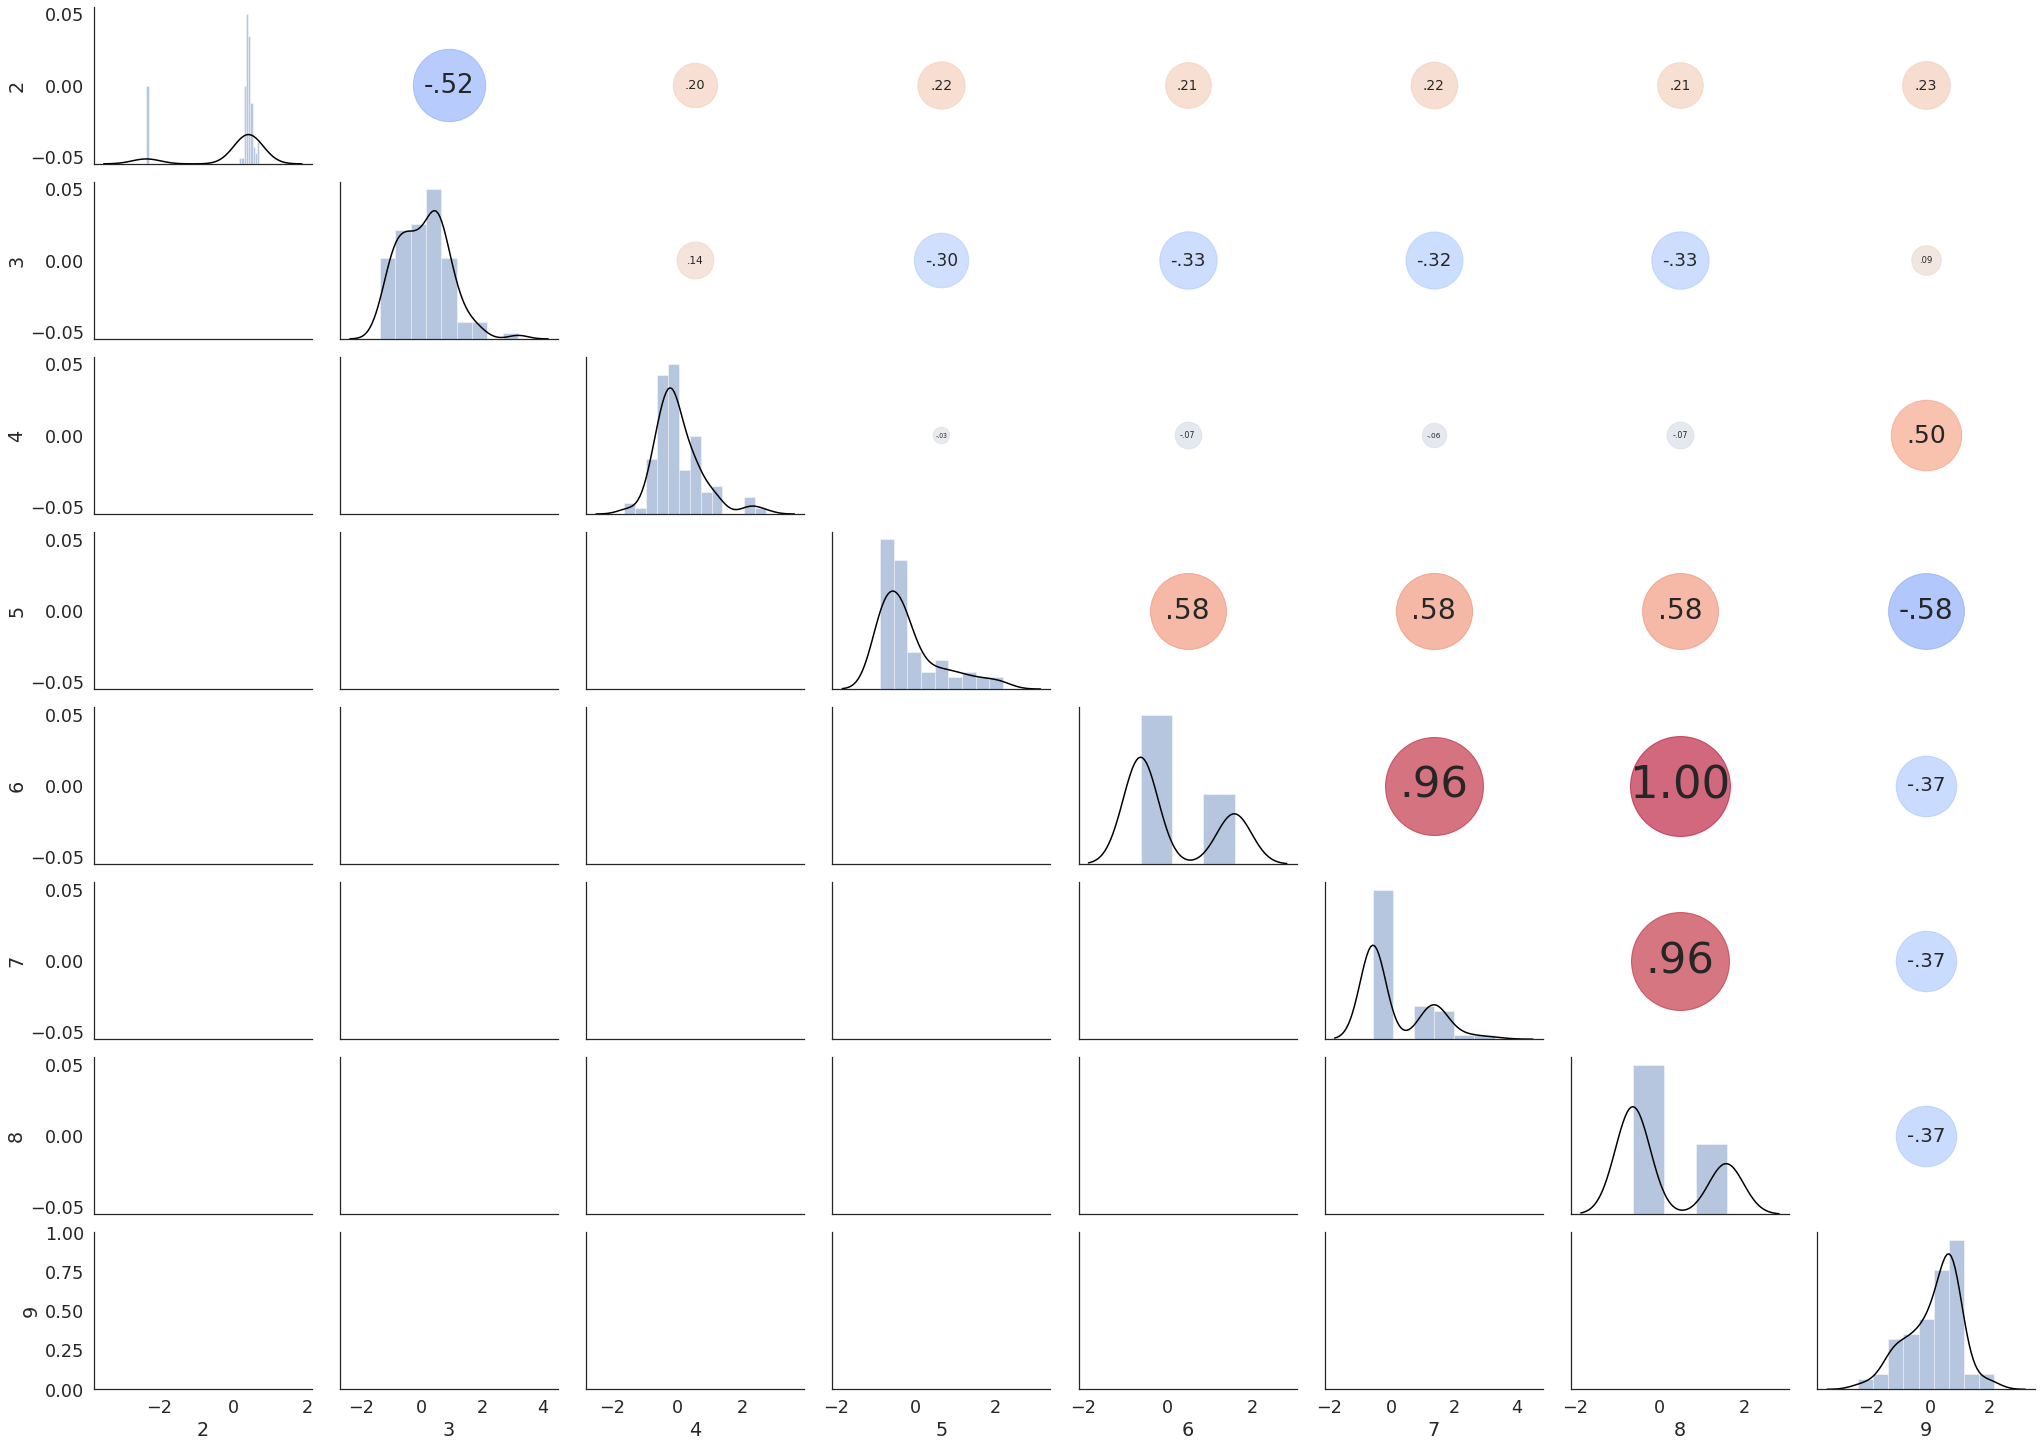

In [50]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df_s, aspect=1.4, diag_sharey=False)
#g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

In [ ]:
g

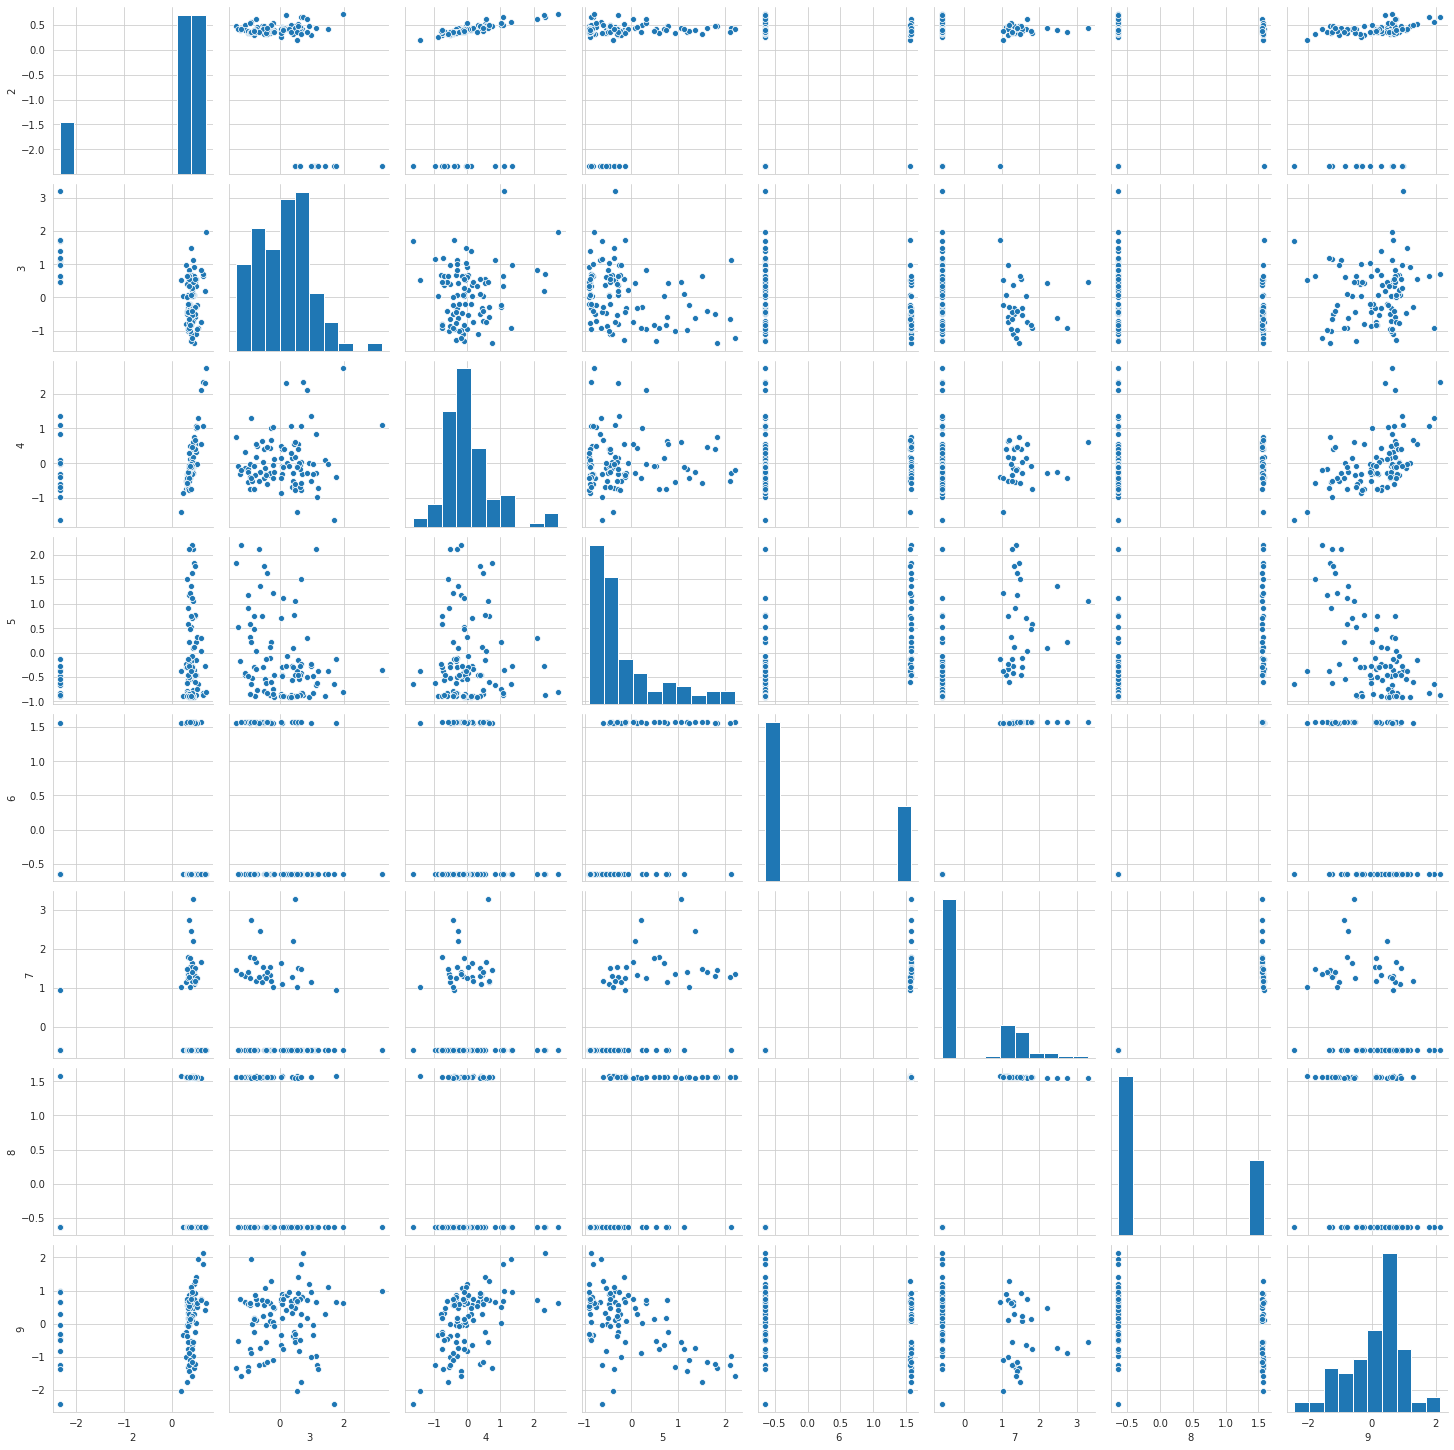

In [48]:
import seaborn as sns
sns.set_style("whitegrid");
sns.pairplot(df_s);
plt.show()

NameError: name 'tX_plot_stand' is not defined

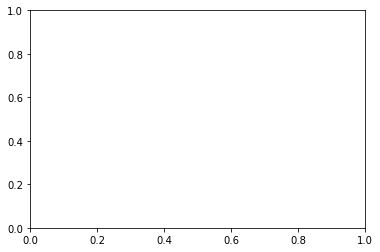

In [13]:
# boxplots of standardized features
fig, ax = plt.subplots()
ax.boxplot(tX_p[:,]);
ax.set_xticklabels(np.arange(0,30,1));
ax.set_xlabel("Features");
ax.set_ylabel("Standardized Values");
ax.set_title("Boxplot of standardized features");

In [11]:
# get indices sorted by variance of unstandardized trainings data
s = np.std(tX_plot , axis = 0)
s = np.argsort(s).tolist()

# feature 12 in [0,1]
# feature 22 in {2,3}
# feature 14, 17 in [-2.5, 2.5]
# feature 20, 18, 25 in [-3.142, 3.142]

NameError: name 'tX_plot' is not defined

NameError: name 'tX_plot' is not defined

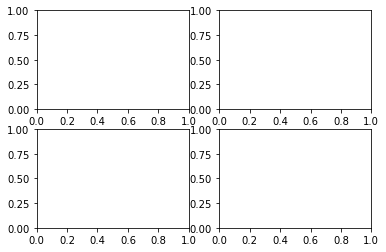

In [10]:
# histograms of features
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)
ax1.hist(tX_plot[:,s[:5]], bins = 100, histtype='step', stacked=True, fill=False);
ax2.hist(tX_plot[:,s[5:15]], bins = 100, histtype='step', stacked=True, fill=False);
ax3.hist(tX_plot[:,s[15:25]], bins = 100, histtype='step', stacked=True, fill=False);
ax4.hist(tX_plot[:,s[25:]], bins = 100, histtype='step', stacked=True, fill=False);
ax1.set_title("Histogram of unstandardized features");
# find a faster way to freshen up plot

ax1.set_yticklabels([]);
ax2.set_yticklabels([]);
ax3.set_yticklabels([]);
ax4.set_yticklabels([]);

## 2. Preprocessing

In [9]:
# Normalize dataset
for indx_col in range(tX.shape[1]):
    tX_st[:, indx_col] = (tX[:, indx_col] - np.mean(tX[:, indx_col])) / np.std(tX[:, indx_col])

# Split dataset
split_perc = 0.7
split_ind = int(len(y) * split_perc)

# Training set
y_train = y[:split_ind]
tX_train = tX[:split_ind]
ids_train = ids[:split_ind]

# Validation set
y_val = y[split_ind:]
tX_val = tX[split_ind:]
ids_val = ids[split_ind:]

## 3. Training

In [ ]:
# Set hyperparameters
max_iters = 100
gamma = 0.01
lambda_ = 0.1

# Initialize weights
initial_w = np.random.rand(D,)

from implementations import *
# Train
#weights_ls_GD, loss_ls_GD = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
#print(loss_ls_GD)
#weights_ls_SGD, loss_ls_SGD = least_squares_SGD(y_train, tX_train, initial_w, max_iters, gamma)
#weights_ls, loss_ls = least_squares(y_train, tX_train)
# weights_rr, loss_rr = ridge_regression(y_train, tX_train, lambda_)
# weights_lr, loss_lr = logistic_regression(y_train, tX_train, initial_w, max_iters, gamma)
# weights_reg_lr, loss_reg_lr = reg_logistic_regression(y_train, tX_train, lambda_, initial_w, max_iters, gamma)

## 4. Evaluation

In [ ]:
from utils import cross_validation, build_k_indices
# Cross-validation

k = 5
k_indices = build_k_indices(y, k)
ls_GD_losses = []
ls_losses = []

for k_iteration in range(k):
    tX_train, y_train, tX_val, y_val = cross_validation(y, tX, k_indices, k_iteration)
    weights_ls_GD, loss_ls_GD = least_squares_GD(y_train, tX_train, initial_w, max_iters, gamma)
    weights_ls, loss_ls = least_squares(y_train, tX_train)

    y_pred_ls_GD_val = tX_val @ weights_ls_GD
    y_pred_ls_val = tX_val @ weights_ls

    ls_GD_losses.append(calculate_mse_loss(y_val, y_pred_ls_val))
    ls_losses.append(calculate_mse_loss(y_val, y_pred_ls_val))

ls_GD_losses = np.array(ls_GD_losses)
ls_losses = np.array(ls_losses)

ls_GD_mean_loss = np.mean(ls_GD_losses)
ls_mean_loss = np.mean(ls_losses)

print(ls_GD_mean_loss, ls_mean_loss)

## Generate predictions and save output in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
# TODO: decide real weights
weights = least_squares_GD(y, tX, initial_w, max_iters, gamma)
OUTPUT_PATH = '../data/submission.csv'
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)